In [1]:
!unzip /content/YOLO_test.zip -d /content/

Archive:  /content/YOLO_test.zip
  inflating: /content/YOLO_test/0.png  
  inflating: /content/YOLO_test/1.png  
  inflating: /content/YOLO_test/10.png  
  inflating: /content/YOLO_test/11.png  
  inflating: /content/YOLO_test/12.png  
  inflating: /content/YOLO_test/13.png  
  inflating: /content/YOLO_test/14.png  
  inflating: /content/YOLO_test/15.png  
  inflating: /content/YOLO_test/16.png  
  inflating: /content/YOLO_test/17.png  
  inflating: /content/YOLO_test/18.png  
  inflating: /content/YOLO_test/19.png  
  inflating: /content/YOLO_test/2.png  
  inflating: /content/YOLO_test/20.png  
  inflating: /content/YOLO_test/21.png  
  inflating: /content/YOLO_test/22.png  
  inflating: /content/YOLO_test/23.png  
  inflating: /content/YOLO_test/24.png  
  inflating: /content/YOLO_test/25.png  
  inflating: /content/YOLO_test/26.png  
  inflating: /content/YOLO_test/27.png  
  inflating: /content/YOLO_test/28.png  
  inflating: /content/YOLO_test/29.png  
  inflating: /content/YOLO_

device is cuda


In [8]:
import torch
import torchvision
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor




# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device is {device}")

def collate_fn(batch):
    images = [item[0] for item in batch]
    annotations = [item[1] for item in batch]

    images = torch.stack(images, dim=0)

    # No need to change annotations, keep them as a list of dictionaries
    return images, annotations


class ChipsDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((224,224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        else:
            self.transform = transform


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.img_dir, f"{img_id}")).convert("RGB")

        # Transform the image to a tensor (apply only once)
        img = self.transform(img)

        # Extract and process annotations
        x_center, y_center, width, height = self.annotations.iloc[index, 1:5]
        class_id = 1  # Replace with actual class_id if available

        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2
        bbox = [x_min, y_min, x_max, y_max]

        annotation = {'boxes': torch.tensor([bbox], dtype=torch.float32),
                      'labels': torch.tensor([class_id], dtype=torch.int64)}

        return img, annotation





# Load the dataset
data_dir = "YOLO_test"
dataset = ChipsDataset(csv_file=data_dir+"/truth.csv", img_dir=data_dir)






train_size = 0.7
val_size = 1-train_size

# Splitting dataset into training and validation sets
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])





# Define data loaders with the custom collate function
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False, collate_fn=collate_fn)

# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Update the number of classes (including the background)
num_classes = 2  # 1 class (your class) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = fasterrcnn_resnet50_fpn(in_features, num_classes)
# Replace the classifier with a new one for your number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function
loss_function = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



num_epochs = 10





device is cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' and 'progress' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Training:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/tor

In [ ]:
# Training loop
for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    for imgs, annotations_list in train_loader:
        imgs = imgs.to(device)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations_list]

        optimizer.zero_grad()
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
    # Validation loop
    model.eval()
    with torch.no_grad():
        for imgs, annotations_list in val_loader:
            imgs = imgs.to(device)

            # Forward pass, get model predictions
            predictions = model(imgs)

In [9]:
def calculate_iou(pred_box, gt_box):
    """
    Calculate IoU of a single predicted box and a single ground truth box.

    :param pred_box: Predicted bounding box [x1, y1, x2, y2]
    :param gt_box: Ground truth bounding box [x1, y1, x2, y2]
    :return: IoU value
    """
    # Determine the coordinates of the intersection rectangle
    x_left = max(pred_box[0], gt_box[0])
    y_top = max(pred_box[1], gt_box[1])
    x_right = min(pred_box[2], gt_box[2])
    y_bottom = min(pred_box[3], gt_box[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate union area
    pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    union_area = pred_box_area + gt_box_area - intersection_area

    # Compute the IoU
    iou = intersection_area / union_area
    return iou

# Training loop
for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    train_loss = 0
    for imgs, annotations_list in train_loader:
        imgs = imgs.to(device)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations_list]

        optimizer.zero_grad()
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())
        train_loss += losses.item()
        losses.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch}, Training loss: {avg_train_loss}')

    # Validation loop
    model.eval()
    val_iou = []
    with torch.no_grad():
        for imgs, annotations_list in val_loader:
            imgs = imgs.to(device)

            predictions = model(imgs)

            for i, pred in enumerate(predictions):
                gt_boxes = annotations_list[i]['boxes'].cpu().numpy()
                pred_boxes = pred['boxes'].cpu().numpy()

                for gt_box in gt_boxes:
                    ious = [calculate_iou(pred_box, gt_box) for pred_box in pred_boxes]
                    if ious:
                        max_iou = max(ious)
                        val_iou.append(max_iou)

    avg_iou = sum(val_iou) / len(val_iou) if val_iou else 0
    print(f'Epoch {epoch}, Validation IoU: {avg_iou}')


Training:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0, Training loss: 0.1266840562224388


Training:  10%|█         | 1/10 [00:07<01:05,  7.28s/it]

Epoch 0, Validation IoU: 0.02598376472791036
Epoch 1, Training loss: 0.10930643305182457


Training:  20%|██        | 2/10 [00:14<00:58,  7.28s/it]

Epoch 1, Validation IoU: 0.008282541731993357
Epoch 2, Training loss: 0.12364706546068191


Training:  30%|███       | 3/10 [00:21<00:51,  7.32s/it]

Epoch 2, Validation IoU: 0.06450686493141498
Epoch 3, Training loss: 0.19369886219501495


Training:  40%|████      | 4/10 [00:29<00:44,  7.36s/it]

Epoch 3, Validation IoU: 0.06615464784166154
Epoch 4, Training loss: 0.13786155730485916


Training:  50%|█████     | 5/10 [00:36<00:37,  7.40s/it]

Epoch 4, Validation IoU: 0.04826955075065295
Epoch 5, Training loss: 0.17517918050289155


Training:  60%|██████    | 6/10 [00:44<00:29,  7.45s/it]

Epoch 5, Validation IoU: 0.09238043952306423
Epoch 6, Training loss: 0.13313492387533188


Training:  70%|███████   | 7/10 [00:51<00:22,  7.49s/it]

Epoch 6, Validation IoU: 0.07791440462654767
Epoch 7, Training loss: 0.1088083803653717


Training:  80%|████████  | 8/10 [00:59<00:15,  7.51s/it]

Epoch 7, Validation IoU: 0.08569549940099629
Epoch 8, Training loss: 0.08378992155194283


Training:  90%|█████████ | 9/10 [01:07<00:07,  7.56s/it]

Epoch 8, Validation IoU: 0.03590950211510062
Epoch 9, Training loss: 0.10106071531772613


Training: 100%|██████████| 10/10 [01:14<00:00,  7.48s/it]

Epoch 9, Validation IoU: 0.1574951872540017


In [13]:
def unnormalize(img):
    """
    Undo the normalization on an image tensor.

    :param img: Normalized image tensor.
    :return: Unnormalized image tensor.
    """
    device = img.device  # Get the device of the input tensor
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(-1, 1, 1)
    img = img * std + mean  # Reversing normalization
    img = img.clamp(0, 1)   # Clamping to the valid range
    return img


In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Image 0: Found 27 boxes.
Score: 0.3285922706127167
Score: 0.3121598958969116
Score: 0.3053564727306366
Score: 0.2544627785682678
Score: 0.25303709506988525
Score: 0.2227974534034729
Score: 0.20229430496692657
Score: 0.19851864874362946
Score: 0.19219723343849182
Score: 0.18952739238739014
Score: 0.1883641481399536
Score: 0.18356460332870483
Score: 0.18319986760616302
Score: 0.17173121869564056
Score: 0.16999734938144684
Score: 0.16015537083148956
Score: 0.1490558385848999
Score: 0.14805634319782257
Score: 0.14332573115825653
Score: 0.12387199699878693
Score: 0.11063552647829056
Score: 0.09930774569511414
Score: 0.09800919890403748
Score: 0.07758158445358276
Score: 0.06742523610591888
Score: 0.058826472610235214
Score: 0.05120496451854706
Image 1: Found 14 boxes.
Score: 0.16842728853225708
Score: 0.14013783633708954
Score: 0.11694426834583282
Score: 0.09144032001495361
Score: 0.0858968198299408
Score: 0.07958173751831055
Score: 0.07818092405796051
Score: 0.07342976331710815
Score: 0.067

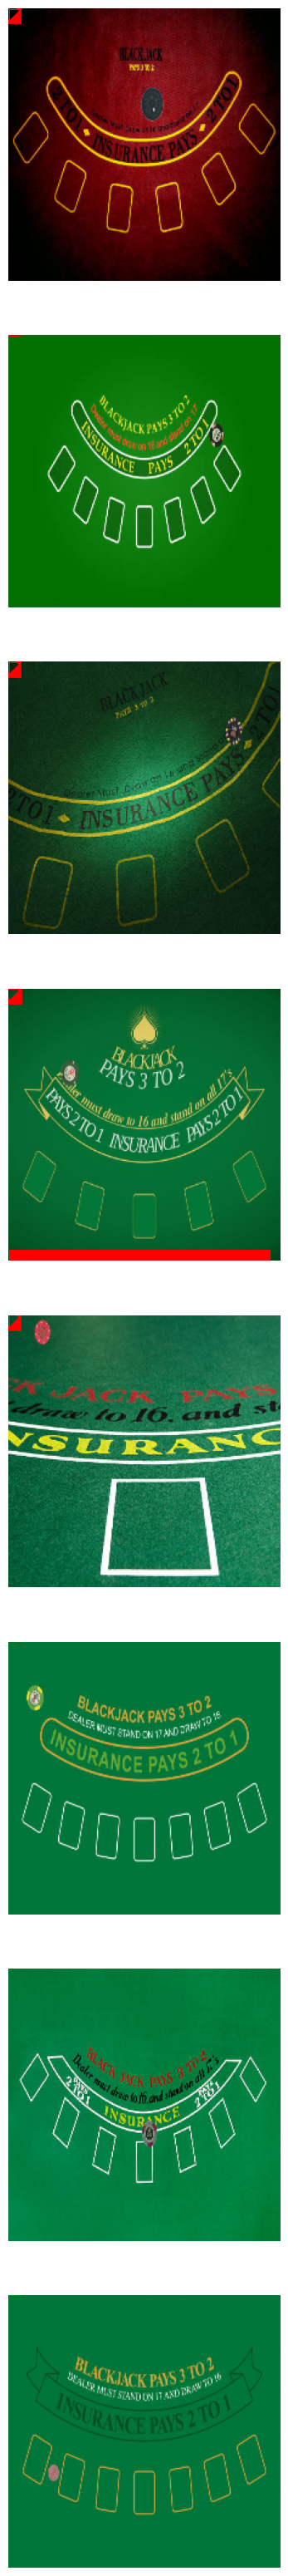

In [20]:


def show_predictions(imgs, predictions, threshold=0.1):
    """
    Show images with predicted bounding boxes.

    :param imgs: Batch of images.
    :param predictions: Corresponding predictions from the model.
    :param threshold: Threshold for prediction score.
    """
    fig, axs = plt.subplots(len(imgs), 1, figsize=(10, len(imgs) * 5))

    for i, img in enumerate(imgs):
        img = unnormalize(img).permute(1, 2, 0).cpu().numpy()
        ax = axs if len(imgs) == 1 else axs[i]
        ax.imshow(img)

        if predictions[i]['boxes'] is not None:
            print(f"Image {i}: Found {len(predictions[i]['boxes'])} boxes.")  # Debugging print
            for box, score in zip(predictions[i]['boxes'], predictions[i]['scores']):
                print(f"Score: {score}")  # Debugging print
                if score > threshold:
                    xmin, ymin, xmax, ymax = box.cpu().numpy()
                    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=20, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)

        ax.axis('off')
    plt.show()

# Rest of the code to load images, get predictions, and display


# Load a batch of images from the validation set
imgs, _ = next(iter(val_loader))
imgs = [img.to(device) for img in imgs]

# Model in evaluation mode
model.eval()
with torch.no_grad():
    predictions = model(imgs)

# Convert images back to CPU and display
show_predictions(imgs, predictions)
